### Perform maximum likelihood estimation using the principle of Delta-map to calculate a clean map.

In [4]:
using NPZ
using PyPlot, Statistics, Distributions
include("../src/function/extended_delta_map.jl")
include("../src/function/set_data_model.jl")
# set parameters
freq_bands = [40, 60, 140]
#freq_bands = [40, 50, 60, 68, 78, 89, 100, 119, 140]
#freq_bands = [40, 50, 60, 68, 78, 89, 100, 119, 140, 166, 195, 235, 280, 337, 402]; #GHz
which_model = "s1"
r_input = 0.01
seed = 2
nside = 4
num_I = 2  
noise = false
cov_mat_scal = npzread("../covariance_matrix/smoothing_cov_mat_scal_nside_$(nside).npy")
cov_mat_tens = npzread("../covariance_matrix/smoothing_cov_mat_tens_nside_$(nside).npy")
mask_path = "../mask_p06_Nside4.v2.fits"
#mask_path = "../P06_nside_8.fits"
mask = hp.read_map(mask_path).*0 .+1;
N⁻¹_set = Matrix{Float64}[]  
m_set = Vector{Float64}[]  
r_est = 0.5

# definite SetParams and FitParams struct
set_params = SetParams(freq_bands, which_model, r_input, seed, nside, num_I, cov_mat_scal, cov_mat_tens, mask, m_set, N⁻¹_set)
fit_params = FitParams(-3, 1.5, 20.1, r_est);

In [5]:
set_num_I_with_cmb!(set_params)
set_N⁻¹_ml!(set_params, noise)
set_m_vec_ml!(set_params, noise);
clean_Q, clean_U = calc_clean_map_cmb(set_params, fit_params);

sys:1: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 


In [6]:
clean_cl = hp.anafast([clean_Q, clean_Q, clean_U], lmax=2*nside);

In [11]:
base_dir_cmb = "../map_file/cmb_map/"
nside_str = "_nside_$(set_params.nside)"
r_name = "r_"
r_n = string(set_params.r_input)
seed_name = "_seed_"
seed_n = string(set_params.seed)
GHz = "_GHz"
Cmb_name = joinpath(base_dir_cmb, "$(r_name)$(r_n)$(nside_str)$(seed_name)$(seed_n)")
cmb_data_Q = hp.read_map(Cmb_name, field=1)
cmb_data_U = hp.read_map(Cmb_name, field=2);

In [12]:
input_fwhm = 2200 * (4/nside)^2
smoothed_cmb = smoothing_map_fwhm([cmb_data_Q,cmb_data_Q,cmb_data_U], input_fwhm, set_params.nside);
smoothed_Q, smoothed_U = smoothed_cmb[2, :], smoothed_cmb[3, :];
smoothed_cmb_cl  = hp.anafast([smoothed_Q, smoothed_Q, smoothed_U], lmax=2*nside);
cmb_cl = hp.anafast([cmb_data_Q, cmb_data_Q, cmb_data_U], lmax=2*nside);

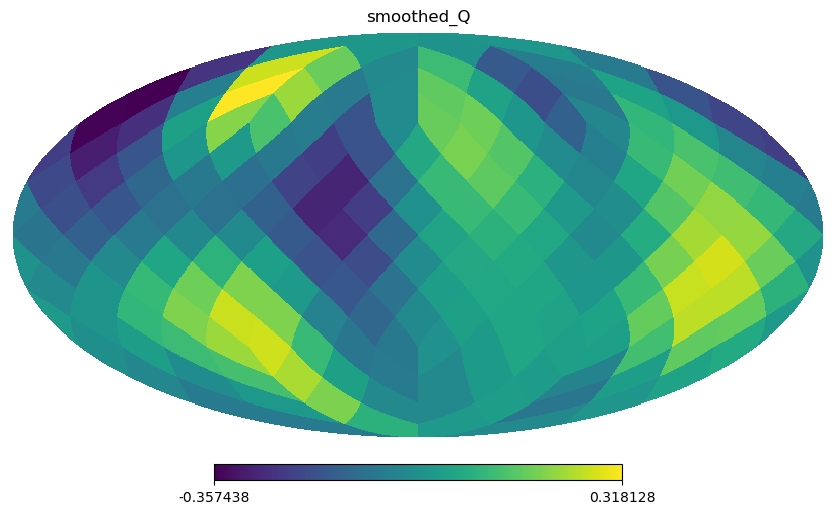

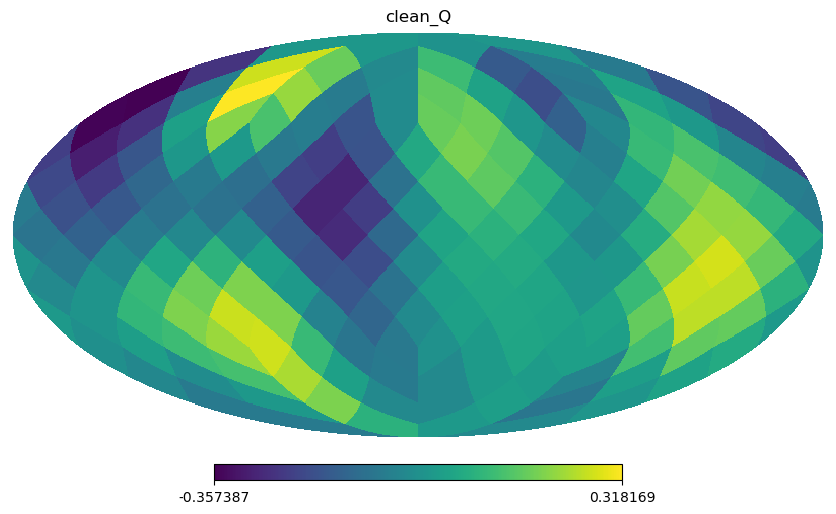

In [13]:
hp.mollview(smoothed_Q, title="smoothed_Q")
hp.mollview(clean_Q, title="clean_Q")

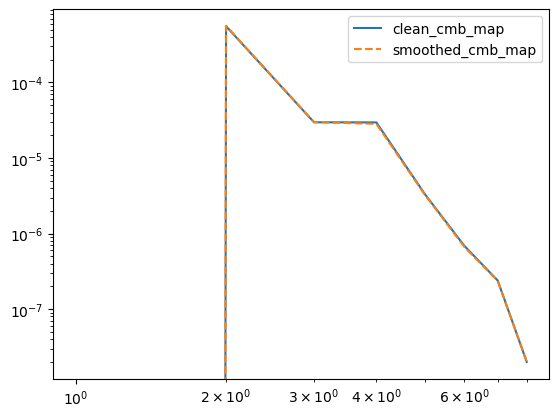

PyObject <matplotlib.legend.Legend object at 0x3338d62d0>

In [14]:
plt.loglog(clean_cl[3, :], label="clean_cmb_map")
plt.loglog(smoothed_cmb_cl[3, :], label="smoothed_cmb_map", linestyle="dashed")
plt.legend()

### Estimate parameters by iteratively performing maximum likelihood estimation using the calculated clean map.

In [15]:
using NPZ
using PyPlot, Statistics, Distributions
# test function
include("../src/function/extended_delta_map.jl")
include("../src/function/r_estimate_extended.jl")
include("../src/function/set_data_model.jl")
# set parameters
freq_bands = [40, 60, 140]
freq_bands = [40, 50, 60, 68, 78, 89, 100, 119]
#freq_bands = [40, 50, 60, 68, 78, 89, 100, 119, 140, 166, 195, 235, 280, 337, 402]; #GHz
which_model = "s1"
r_input = 0.01
seed = 2
nside = 4
num_I = 2  
noise = true
cov_mat_scal = npzread("../covariance_matrix/smoothing_cov_mat_scal_nside_$(nside).npy")
cov_mat_tens = npzread("../covariance_matrix/smoothing_cov_mat_tens_nside_$(nside).npy")
mask_path = "../mask_p06_Nside4.v2.fits"
#mask_path = "../P06_nside_8.fits"
mask = hp.read_map(mask_path);
N⁻¹_set = Matrix{Float64}[]  
m_set = Vector{Float64}[]  
r_est = 0.5

# definite SetParams and FitParams struct
set_params = SetParams(freq_bands, which_model, r_input, seed, nside, num_I, cov_mat_scal, cov_mat_tens, mask, m_set, N⁻¹_set)
fit_params = FitParams(-3, 1.5, 20.1, r_est);

In [16]:
set_num_I_with_cmb!(set_params)
set_N⁻¹_ml!(set_params, noise)
set_m_vec_ml!(set_params, noise);

In [17]:
iterative_minimization_pix_based(set_params, fit_params, noise)

Iteration 1: r = 0.007855880337117815, Likelihood = -2260.3019410871543
delta_like = 1.000000226030194e10
delta_r = 0.4921441196628822


/opt/anaconda3/envs/fg_env/lib/python3.12/site-packages/iminuit/minuit.py:2944: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  fm = migrad(ncall, tolerance)


Iteration 2: r = 0.007856659098629426, Likelihood = -2260.347455327154
delta_like = 0.04551423999964754
delta_r = 7.787615116106039e-7
Iteration 3: r = 0.007856659098629426, Likelihood = -2260.347461450632
delta_like = 6.123478215158684e-6
delta_r = 0.0


In [18]:
r_dis, beta_s_dis, _, _ = estimate_r_distribution_pix_based(set_params, fit_params, 10, noise)

Iteration 1: r = 0.006530249408663036, Likelihood = -2284.0530327370425
delta_like = 1.0000002284053032e10
delta_r = 0.0013264096899663902
Iteration 2: r = 0.00652768572485285, Likelihood = -2284.054768983652
delta_like = 0.0017362466096528806
delta_r = 2.5636838101861237e-6
Iteration 1: r = 0.007856487128657275, Likelihood = -2260.3474614686775
delta_like = 1.0000002260347462e10
delta_r = 1.7196997215140897e-7
Iteration 2: r = 0.007856487128657275, Likelihood = -2260.3474614686775
delta_like = 0.0
delta_r = 0.0
Iteration 1: r = 0.00624498719889971, Likelihood = -2296.202301730787
delta_like = 1.0000002296202301e10
delta_r = 0.0016116718997297164
Iteration 2: r = 0.006242828156935554, Likelihood = -2296.203995362981
delta_like = 0.001693632194019301
delta_r = 2.15904196415595e-6
Iteration 1: r = 0.011807260232362615, Likelihood = -2238.1585421860404
delta_like = 1.0000002238158543e10
delta_r = 0.003950601133733189
Iteration 2: r = 0.011811440522455918, Likelihood = -2238.162704367357
d

(Any[0.00652768572485285, 0.007856487128657275, 0.006242828156935554, 0.011811440522455918, 0.013822703972270645, 0.011251442414292712, 0.008583844838215171, 0.011774680253596626, 0.008023244571379817, 0.008811679299793596], Any[-3.117859666775247, -2.965464733256697, -2.907982462463293, -2.993290826502278, -2.8530098186311053, -2.8880615640039724, -2.9780042773561917, -2.9271555957568953, -3.0425679656029785, -2.8399889174295363], Any[1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5], Any[20.1, 20.1, 20.1, 20.1, 20.1, 20.1, 20.1, 20.1, 20.1, 20.1])

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


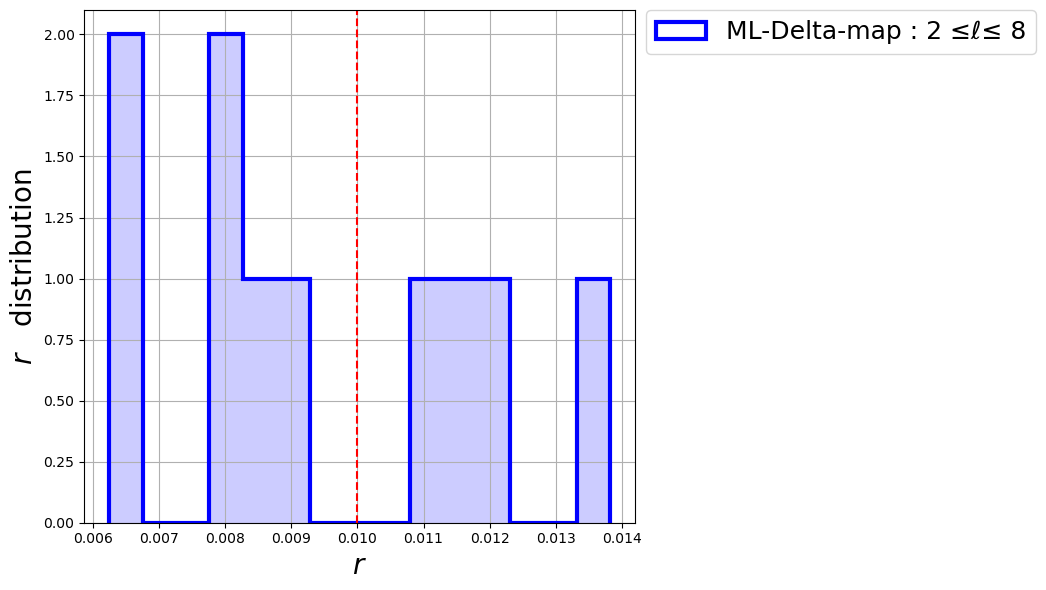

In [19]:
figure(figsize=(8, 6))
hist(r_dis, bins=15, alpha=0.2, color="blue", histtype="stepfilled")
hist(r_dis, bins=15, alpha=1., edgecolor="blue", label="ML-Delta-map : 2 ≤ℓ≤ 8", histtype="step", linewidth=3)
axvline(x=r_input, color="red", linestyle="--")
xlabel(L"$r$", fontsize=20)
ylabel(L"$r\quad$distribution", fontsize=20)  
plt.grid(true)
legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize="18")
tight_layout()
subplots_adjust(right=0.8)
show()

In [20]:
fit_params

FitParams(-2.965464657851935, 1.5, 20.1, 0.007856659098629426)